In [1]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
import itertools
from matplotlib import pyplot as plt

from ms_entropy.file_io.msp_file import read_one_spectrum
import numba as nb
import pyteomics.mgf
import sys
import importlib
import re

sys.path.append("../../src/ms_similarity_metrics/")
from create_spectrum import smile2inchi
importlib.reload(sys.modules['create_spectrum'])
from create_spectrum import smile2inchi


# Get queries

In [3]:
# List of metrics that were used in the queries
metric_names = ['bhattacharya_2', 'manhattan', 'entropy']

# Read in the queries
# queries = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/spec_entropy_queries/query_no_ppm.csv', 
#                       index_col=0)
# weighted_queries = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/spec_entropy_queries/weighted_query_no_ppm.csv',
#                                index_col=0)
queries = pd.read_csv('../../data/spec_entropy_queries/query_no_ppm.csv', index_col=0)
weighted_queries = pd.read_csv('../../data/spec_entropy_queries/weighted_query_no_ppm.csv', index_col=0)

# Filter the queries to only include queries that were in both the weighted and unweighted queries
queries = queries[queries['wout_identifier'].isin(weighted_queries['wout_identifier'])]
weighted_queries = weighted_queries[weighted_queries['wout_identifier'].isin(queries['wout_identifier'])]

In [4]:
# Reformat the library_spectra_matches column for the unweighted queries
new_columns = {name:{} for name in metric_names}
non_decimal = re.compile(r'[^\d.]+')
for query in tqdm(queries.index.values):
    metric_scores = queries.loc[query,'library_spectra_matches'].split('{')[1].split('}')[0].split(']')[:-1]
    for i in range(len(metric_scores)):
        matches = []
        current_query = metric_scores[i]
        col_name = current_query.split(':')[0].replace("'",'').replace(',','').strip()
        current_query = current_query.split('[')[1]
        current_query = current_query.replace("'", "").replace(')', '').split('(')[1:]
        for pair in current_query:
            matches.append((pair.split(',')[0], float(non_decimal.sub('', pair.split(',')[1]))))
        new_columns[col_name][query] = matches

# Create new column for each metric
for name in new_columns.keys():
    queries[name] = queries.index.map(new_columns[name])

# Reformat the library_spectra_matches column for the weighted queries
new_columns = {name:{} for name in metric_names}
non_decimal = re.compile(r'[^\d.]+')
for query in tqdm(weighted_queries.index.values):
    metric_scores = weighted_queries.loc[query,'library_spectra_matches'].split('{')[1].split('}')[0].split(']')[:-1]
    for i in range(len(metric_scores)):
        matches = []
        current_query = metric_scores[i]
        col_name = current_query.split(':')[0].replace("'",'').replace(',','').strip()
        current_query = current_query.split('[')[1]
        current_query = current_query.replace("'", "").replace(')', '').split('(')[1:]
        for pair in current_query:
            matches.append((pair.split(',')[0], float(non_decimal.sub('', pair.split(',')[1]))))
        new_columns[col_name][query] = matches

# Create new column for each metric
for name in new_columns.keys():
    weighted_queries[name] = weighted_queries.index.map(new_columns[name])


100%|██████████| 29985/29985 [03:26<00:00, 145.29it/s]


# Get NIST23 data

In [5]:
# Get NIST23 library
# Get data from s3://enveda-data-user/chloe.engler/cosine_similarity/NIST_data/NIST23-HR-MSMS.MSP
spectra_list = []
for i,spectrum in tqdm(enumerate(read_one_spectrum('../../data/NIST23-HR-MSMS.MSP'))):
    spectra_list.append(spectrum)

1934658it [04:00, 8059.84it/s] 


In [6]:
# Create NIST dataframe
nist_df = pd.DataFrame(spectra_list)
nist_df = nist_df[nist_df['precursor_type'] == '[M+H]+' ]

# Get Wout data

In [7]:
# Profile spectra contain 0 intensity values.
@nb.njit
def is_centroid(intensity_array):
    return np.all(intensity_array > 0)

In [8]:
# Read all spectra from the MGF.
spectra = []

# Download from https://zenodo.org/record/6829249/files/ALL_GNPS_NO_PROPOGATED.mgf?download=1
filename = ("../../data/ALL_GNPS_NO_PROPOGATED.mgf")

# Get wout spectra
with pyteomics.mgf.MGF(filename) as f_in:
    for spectrum_dict in tqdm(f_in):
        spectra.append(spectrum_dict)

495600it [02:26, 3373.19it/s] 


In [9]:
# Create wout dataframe
wout_df = pd.DataFrame(spectra)
wout_df = pd.concat([wout_df.drop(['params'], axis=1), wout_df['params'].apply(pd.Series)], axis=1)
wout_df.head(2)

,m/z array,intensity array,charge array,pepmass,charge,mslevel,source_instrument,filename,seq,ionmode,...,pi,datacollector,smiles,inchi,inchiaux,pubmed,submituser,libraryquality,spectrumid,scans
0,"[289.286377, 295.545288, 298.489624, 317.32495...","[8068.0, 22507.0, 3925.0, 18742.0, 8604.0, 804...","[--, --, --, --, --, --, --, --, --, --, --, -...","(981.54, None)",[0+],2,LC-ESI-qTof,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,*..*,Positive,...,Gerwick,Jenia,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,N/A,N/A,N/A,mwang87,1,CCMSLIB00000001547,1
1,"[278.049927, 278.957642, 281.258667, 291.99609...","[35793.0, 47593.0, 95495.0, 115278.0, 91752.0,...","[--, --, --, --, --, --, --, --, --, --, --, -...","(940.25, None)",[0+],2,LC-ESI-qTof,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,*..*,Positive,...,Gerwick,Amanda,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,InChI=1S/C45H73N5O10S3/c1-14-17-24(6)34(52)26(...,N/A,N/A,mwang87,1,CCMSLIB00000001548,1


In [10]:
# Get wout metadata
metadata = pd.read_csv(
    'https://zenodo.org/record/6829249/files/gnps_libraries_metadata.csv?download=1'
)
metadata.set_index('id', inplace=True)

# Get library for each query spectra

In [11]:
# Remove wout spectra from NIST
queries['wout_library'] = list(metadata.loc[queries['wout_identifier'],'library'])
queries = queries[queries['wout_library'] != 'GNPS-NIST14-MATCHES']
weighted_queries['wout_library'] = list(metadata.loc[weighted_queries['wout_identifier'],'library'])
weighted_queries = weighted_queries[weighted_queries['wout_library'] != 'GNPS-NIST14-MATCHES']

# Look at number of matches

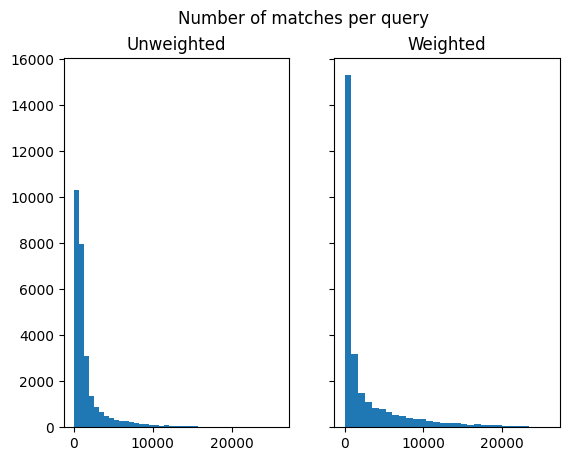

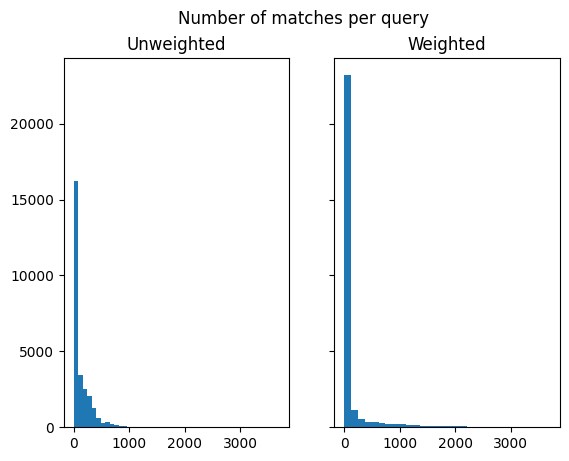

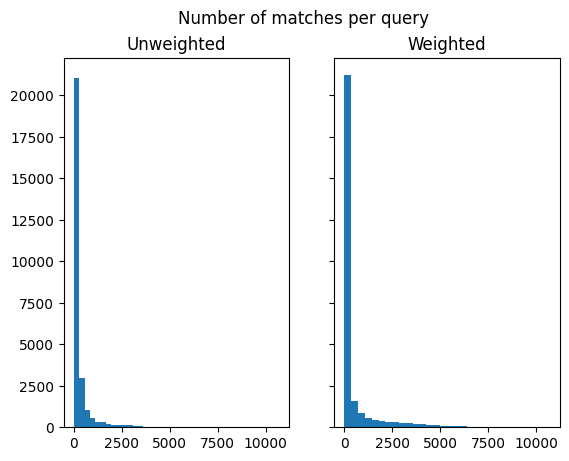

In [12]:
# Look at the number of matches per query for each metric
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

    # Plot the number of matches per query for the unweighted queries
    num_matches = queries[name].apply(lambda x: len(x))
    ax1.hist(num_matches, bins=30)
    ax1.set_title('Unweighted')

    # Plot the number of matches per query for the weighted queries
    num_matches = weighted_queries[name].apply(lambda x: len(x))
    ax2.hist(num_matches, bins=30)
    ax2.set_title('Weighted')

    # Show plot
    plt.suptitle('Number of matches per query')
    plt.show()

# Get smiles

In [13]:
# Get nist smiles dict
nist_smiles_dict = {}
for index in tqdm(nist_df.index.values):
    nist_smiles_dict[index] = nist_df.loc[index,'smiles']

# Get wout smiles dict
wout_smiles_dict = {}
for index in tqdm(wout_df.index.values):
    current_id = wout_df.loc[index, 'spectrumid']
    wout_smiles_dict[current_id] = wout_df.loc[index,'smiles']

100%|██████████| 495600/495600 [00:07<00:00, 66784.77it/s]


In [14]:
# Get wout smiles
for i in tqdm(queries.index.values):
    wout_id = queries.loc[i, 'wout_identifier']
    queries.loc[i, 'wout_smiles'] = wout_smiles_dict[wout_id]

# Get wout smiles
for i in tqdm(queries.index.values):
    wout_id = queries.loc[i, 'wout_identifier']
    weighted_queries.loc[i, 'wout_smiles'] = wout_smiles_dict[wout_id]

100%|██████████| 27430/27430 [00:01<00:00, 17292.29it/s]


# Get inchikeys

In [15]:
# Get NIST23 partial inchikeys for unweighted queries
inchi_dict = {name:{} for name in metric_names}
for i in tqdm(queries.index.values):
    for name in metric_names:
        inchi_list = []
        for pair in queries.loc[i, name]:
            index = int(pair[0].split('_')[0])
            inchi_list.append(nist_df.loc[int(pair[0].split('_')[0]),'inchikey'][:14])
        inchi_dict[name][i] = inchi_list
for name in metric_names:
    queries[f'{name}_inchis'] = queries.index.map(inchi_dict[name])

# Get NIST23 partial inchikeys for weighted queries
inchi_dict = {name:{} for name in metric_names}
for i in tqdm(weighted_queries.index.values):
    for name in metric_names:
        inchi_list = []
        for pair in weighted_queries.loc[i, name]:
            index = int(pair[0].split('_')[0])
            inchi_list.append(nist_df.loc[int(pair[0].split('_')[0]),'inchikey'][:14])
        inchi_dict[name][i] = inchi_list
for name in metric_names:
    weighted_queries[f'{name}_inchis'] = weighted_queries.index.map(inchi_dict[name])

100%|██████████| 27430/27430 [12:56<00:00, 35.31it/s] 


In [16]:
# Get wout partial inchikeys for queries
for i in tqdm(queries.index.values):
    inchi = smile2inchi(queries.loc[i, 'wout_smiles'])
    queries.loc[i, 'wout_inchi'] = inchi[:14]

# Get wout partial inchikeys for weighted queries
for i in tqdm(weighted_queries.index.values):
    inchi = smile2inchi(weighted_queries.loc[i, 'wout_smiles'])
    weighted_queries.loc[i, 'wout_inchi'] = inchi[:14]

100%|██████████| 27430/27430 [00:19<00:00, 1388.01it/s]


# Look at exact matches

In [17]:
# Get indexes of exact matches for queries
all_matches = {name:{} for name in metric_names}
for i in tqdm(queries.index.values):
    for name in metric_names:
        exact_matches = np.where(np.array(list(queries.loc[i, f'{name}_inchis'])) == queries.loc[i, 'wout_inchi'])[0]
        all_matches[name][i] = exact_matches
for name in metric_names:
    queries[f'{name}_exact_matches'] = queries.index.map(all_matches[name])

# Get indexes of exact matches for weighted queries
all_matches = {name:{} for name in metric_names}
for i in tqdm(weighted_queries.index.values):
    for name in metric_names:
        exact_matches = np.where(np.array(list(weighted_queries.loc[i, f'{name}_inchis'])) == weighted_queries.loc[i, 'wout_inchi'])[0]
        all_matches[name][i] = exact_matches
for name in metric_names:
    weighted_queries[f'{name}_exact_matches'] = weighted_queries.index.map(all_matches[name])


  0%|          | 0/27430 [00:00<?, ?it/s]/tmp/ipykernel_355527/2279915771.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  exact_matches = np.where(np.array(list(queries.loc[i, f'{name}_inchis'])) == queries.loc[i, 'wout_inchi'])[0]
  0%|          | 0/27430 [00:00<?, ?it/s]/tmp/ipykernel_355527/2279915771.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  exact_matches = np.where(np.array(list(weighted_queries.loc[i, f'{name}_inchis'])) == weighted_queries.loc[i, 'wout_inchi'])[0]
100%|██████████| 27430/27430 [00:13<00:00, 2042.96it/s]


In [18]:
# Set initial variables
all_ranks = {}
all_ranks_weighted = {}
all_rank_1 = {}
all_rank_1_weighted = {}

for name in metric_names:
    # Get all ranks of exact matches for unweighted queries
    all_ranks[name] = list(itertools.chain(*list(queries[f'{name}_exact_matches'])))
    all_ranks_weighted[name] = list(itertools.chain(*list(weighted_queries[f'{name}_exact_matches'])))

    # Get each highest rank of exact matches for unweighted queries
    all_rank_1[name] = [x[0] for x in queries[f'{name}_exact_matches'] if len(x) > 0]
    all_rank_1_weighted[name] = [x[0] for x in weighted_queries[f'{name}_exact_matches'] if len(x) > 0 ]

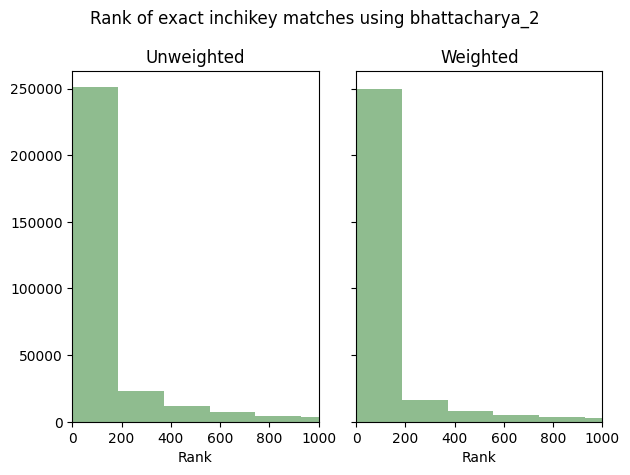

bhattacharya_2: 
Average unweighted top rank:  18.0
Average weighted top rank:  16.0




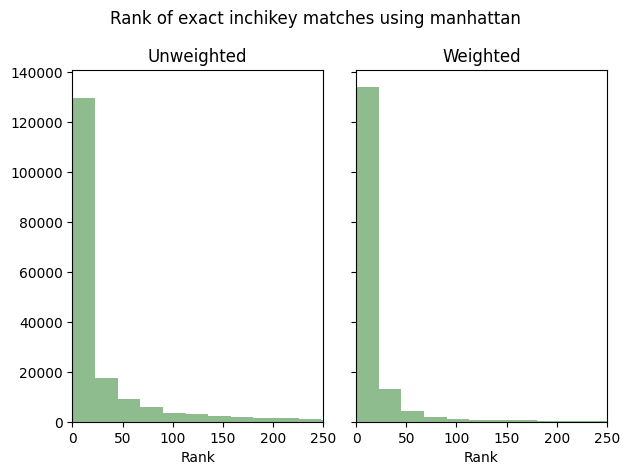

manhattan: 
Average unweighted top rank:  8.0
Average weighted top rank:  6.0




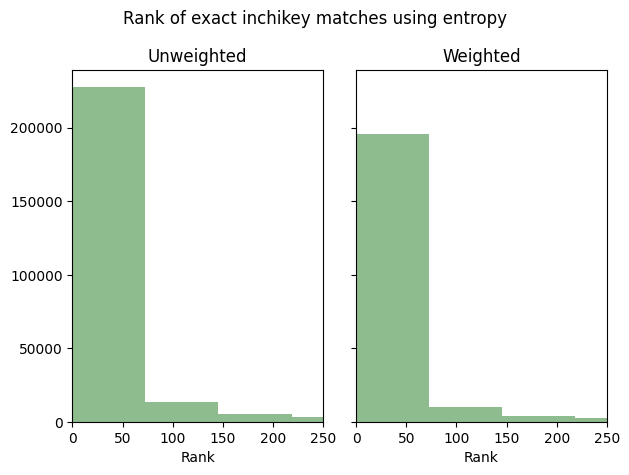

entropy: 
Average unweighted top rank:  9.0
Average weighted top rank:  9.0




In [19]:
# Set initial variables
xlim = {'bhattacharya_2': 1000, 'manhattan': 250, 'entropy': 250}

# Plot the rank of exact matches for each metric
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    # Plot the rank of exact matches for unweighted queries
    _,bins,_ = ax1.hist(all_ranks[name], bins=100, color='darkseagreen')
    ax1.set_title('Unweighted')
    ax1.set_xlim(0, xlim[name])
    ax1.set_xlabel('Rank')

    # Plot the rank of exact matches for weighted queries
    ax2.hist(all_ranks_weighted[name], bins=bins, color='darkseagreen')
    ax2.set_title('Weighted')
    ax2.set_xlim(0, xlim[name])
    ax2.set_xlabel('Rank')

    # Show plot
    plt.suptitle(f'Rank of exact inchikey matches using {name}')
    plt.tight_layout()
    #plt.savefig(f'../figures/rank_{name}.png')
    plt.show()

    print(f'{name}: ')
    print('Average unweighted top rank: ', np.median(all_ranks[name]))
    print('Average weighted top rank: ', np.median(all_ranks_weighted[name]))
    print('\n')

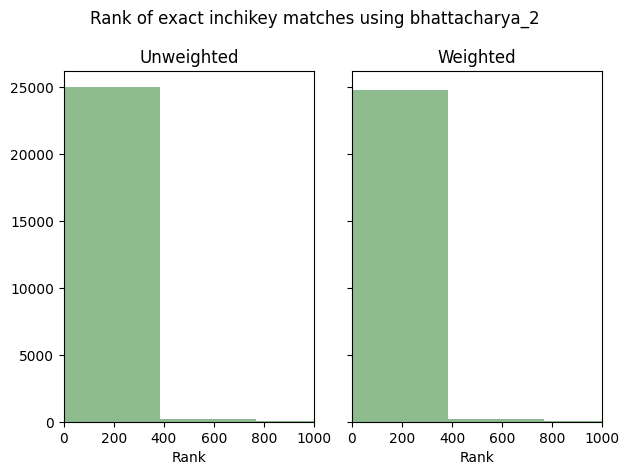

bhattacharya_2: 
Average unweighted rank:  18.0
Average weighted rank:  16.0




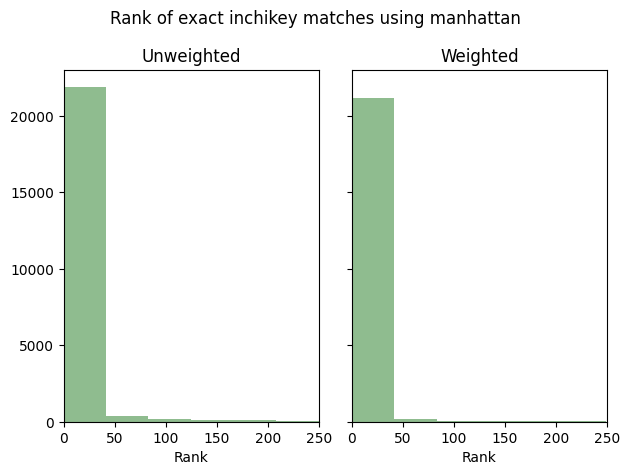

manhattan: 
Average unweighted rank:  8.0
Average weighted rank:  6.0




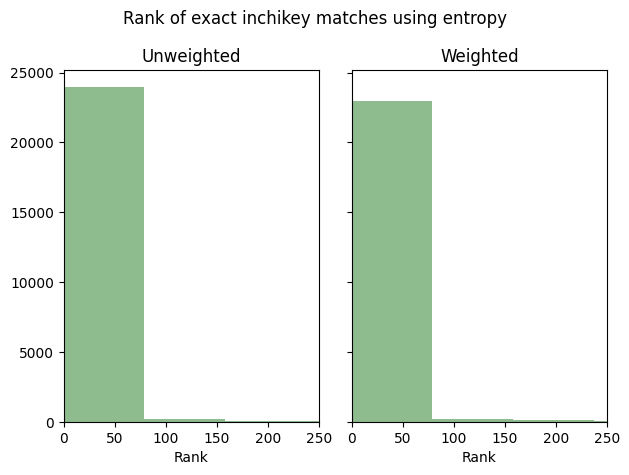

entropy: 
Average unweighted rank:  9.0
Average weighted rank:  9.0




In [20]:
# Plot the highest rank of exact matches for each metric
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    # Plot the highest rank of exact matches for unweighted queries
    _,bins,_ = ax1.hist(all_rank_1[name], bins=30, color='darkseagreen')
    ax1.set_title('Unweighted')
    ax1.set_xlim(0, xlim[name])
    ax1.set_xlabel('Rank')

    # Plot the highest rank of exact matches for weighted queries
    ax2.hist(all_rank_1_weighted[name], bins=bins, color='darkseagreen')
    ax2.set_title('Weighted')
    ax2.set_xlim(0, xlim[name])
    ax2.set_xlabel('Rank')

    # Show plot
    plt.suptitle(f'Rank of exact inchikey matches using {name}')
    plt.tight_layout()
    plt.show()

    print(f'{name}: ')
    print('Average unweighted rank: ', np.median(all_ranks[name]))
    print('Average weighted rank: ', np.median(all_ranks_weighted[name]))
    print('\n')

In [21]:
# Get percent of exact matches for queries
nist_df['partial_inchikey'] = nist_df['inchikey'].str[:14]
for i in tqdm(queries.index.values):
    queries.loc[i, 'num_inchi_matches'] = len(nist_df[nist_df['partial_inchikey'] == queries.loc[i, 'wout_inchi']])
    for name in metric_names:
        queries.loc[i, f'{name}_percent_exact'] = len(queries.loc[i, f'{name}_exact_matches'])/queries.loc[i, 'num_inchi_matches']

# Get percent of exact matches for weighted queries
for i in tqdm(weighted_queries.index.values):
    weighted_queries.loc[i, 'num_inchi_matches'] = len(nist_df[nist_df['partial_inchikey'] == weighted_queries.loc[i, 'wout_inchi']])
    for name in metric_names:
        weighted_queries.loc[i, f'{name}_percent_exact'] = len(weighted_queries.loc[i, f'{name}_exact_matches'])/weighted_queries.loc[i, 'num_inchi_matches']

  1%|          | 176/27430 [00:05<14:16, 31.84it/s]

100%|██████████| 27430/27430 [14:23<00:00, 31.77it/s]


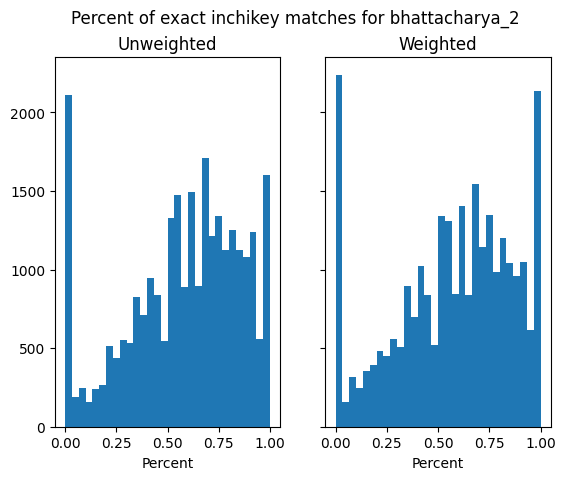

bhattacharya_2: 
Median percent exact matches for unweighted:  0.618421052631579
Median percent exact matches for weighted:  0.6111111111111112




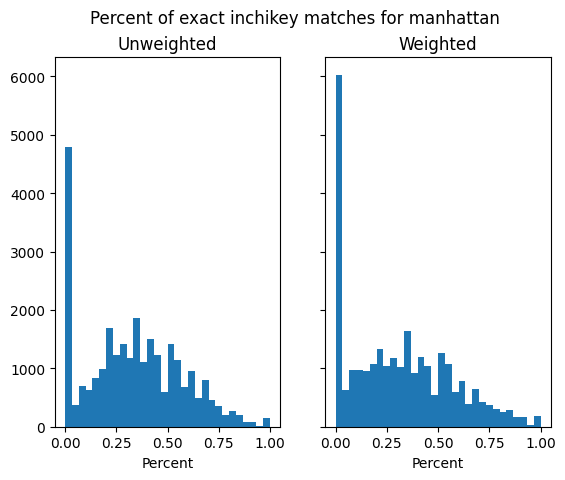

manhattan: 
Median percent exact matches for unweighted:  0.32142857142857145
Median percent exact matches for weighted:  0.2857142857142857




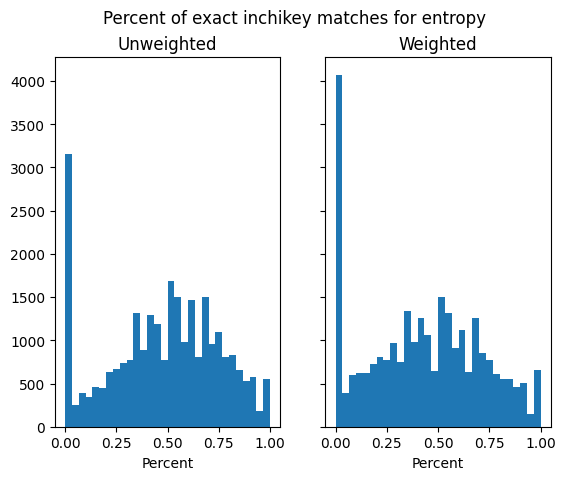

entropy: 
Median percent exact matches for unweighted:  0.5
Median percent exact matches for weighted:  0.42857142857142855




In [22]:
# Plot the percent of exact matches above the threshold for each metric
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    # Plot the percent of exact matches above the threshold for unweighted queries
    ax1.hist(queries[f'{name}_percent_exact'], bins=30)
    ax1.set_title('Unweighted')
    ax1.set_xlabel('Percent')

    # Plot the percent of exact matches above the threshold for weighted queries
    ax2.hist(weighted_queries[f'{name}_percent_exact'], bins=30)
    ax2.set_title('Weighted')
    ax2.set_xlabel('Percent')

    # Show plot
    plt.suptitle(f'Percent of exact inchikey matches for {name}')
    plt.show()

    print(f'{name}: ')
    print('Median percent exact matches for unweighted: ', np.median(queries[f'{name}_percent_exact']))
    print('Median percent exact matches for weighted: ', np.median(weighted_queries[f'{name}_percent_exact']))
    print('\n')

# Look at AUC scores

In [24]:
from sklearn.metrics import roc_curve, auc

# Get AUC scores for queries
for index in tqdm(queries.index.values):
    for name in metric_names:
        if len(np.array(list(queries.loc[index, name]))) != 0:
            prob = np.array(list(queries.loc[index, name]))[:,1].astype('float')
            y_true = np.zeros(len(prob))
            y_true[queries.loc[index,f'{name}_exact_matches']] = 1

            # check if there arent any 1.0s in y_true
            if np.sum(y_true) == 0:
                queries.loc[index, f'{name}_auc'] = 0
            # check if all values are 1.0
            elif np.sum(y_true) == len(y_true):
                queries.loc[index, f'{name}_auc'] = 1
            else:
                fpr, tpr, thresholds = roc_curve(y_true, prob)
                queries.loc[index, f'{name}_auc'] = auc(fpr, tpr)
        else:
            queries.loc[index, f'{name}_auc'] = np.nan

# Get AUC scores for weighted queries
for index in tqdm(weighted_queries.index.values):
    for name in metric_names:
        if len(np.array(list(weighted_queries.loc[index,name]))) != 0:
            prob = np.array(list(weighted_queries.loc[index,name]))[:,1].astype('float')
            y_true = np.zeros(len(prob))
            y_true[weighted_queries.loc[index,f'{name}_exact_matches']] = 1

            # check if there arent any 1.0s in y_true
            if np.sum(y_true) == 0:
                weighted_queries.loc[index, f'{name}_auc'] = 0
            # check if all values are 1.0
            elif np.sum(y_true) == len(y_true):
                weighted_queries.loc[index, f'{name}_auc'] = 1
            else:
                fpr, tpr, thresholds = roc_curve(y_true, prob)
                weighted_queries.loc[index, f'{name}_auc'] = auc(fpr, tpr)
        else:
            weighted_queries.loc[index, f'{name}_auc'] = np.nan

100%|██████████| 27430/27430 [05:16<00:00, 86.63it/s] 


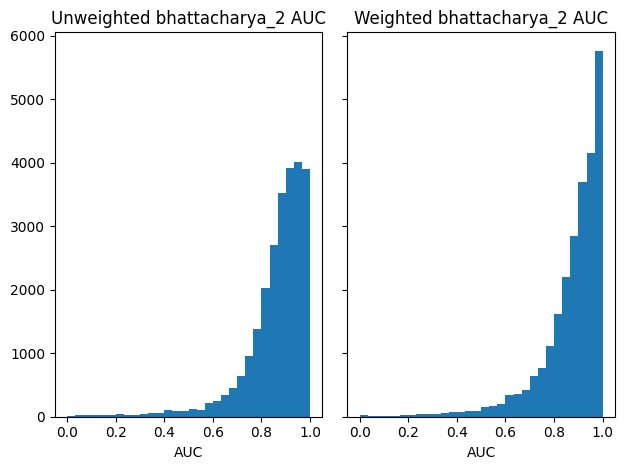

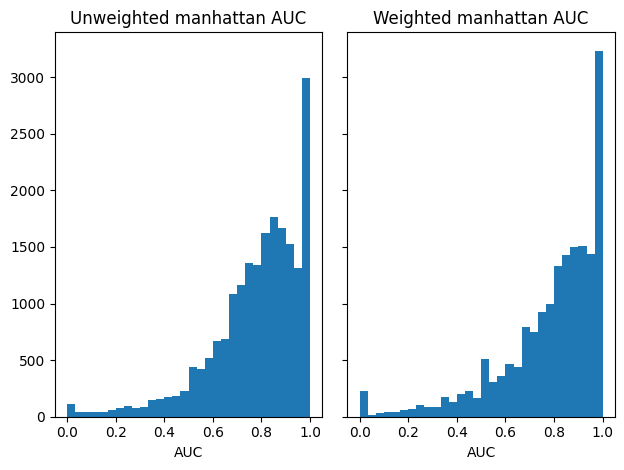

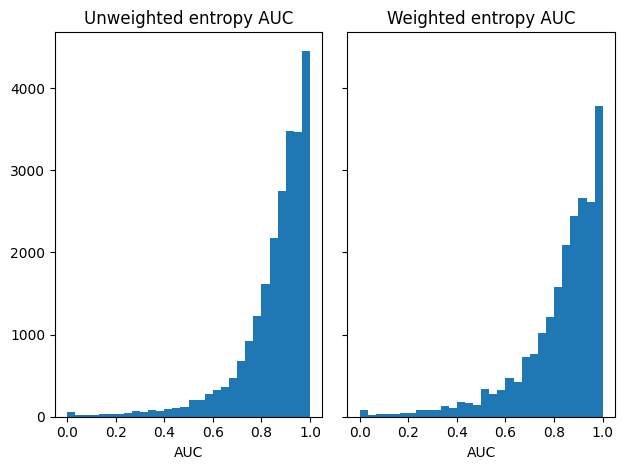

In [32]:
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    ax1.hist(queries[f'{name}_auc'], bins=30)
    ax1.set_title(f'Unweighted {name} AUC')
    ax1.set_xlabel('AUC')

    ax2.hist(weighted_queries[f'{name}_auc'], bins=30)
    ax2.set_title(f'Weighted {name} AUC')
    ax2.set_xlabel('AUC')

    plt.tight_layout()
    plt.show()
    